In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from descartes import PolygonPatch
import matplotlib.gridspec as gridspec

import osmnx as ox
import networkx as nx

In [2]:
from my_osm import get_osm_data
from my_isochrones import get_isochrones

In [3]:
style.use('seaborn-white')
output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [4]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???
# Milano                               (Italy)              EPSG:6875 ???
# Ljubljana                            (Slovenia)           EPSG:8687 ???

place_name = 'The Hague'

In [5]:
output_folder = 'data'
output_sub_folder = '{}_14Sep2023'.format((place_name).split(',')[0].replace(' ', ''))

if place_name == 'Milano':
    local_crs = 'EPSG:6875'
    
elif place_name == 'Ljubljana':
    local_crs = 'EPSG:8687'
    
elif place_name == 'Utrecht':
    local_crs = 'EPSG:28992'
    
elif place_name == 'The Hague':
    local_crs = 'EPSG:28992'

In [6]:
trip_distances = [300]
buffer = max(trip_distances)

In [7]:
tolerance = 10

# Load data

In [8]:
if place_name == 'Milano':
    xmin = 1022678.517
    ymin = 5695916.600
    xmax = 1027342.347
    ymax = 5698126.489
    
elif place_name == 'Ljubljana':
    xmin =  1612551.082
    ymin =  5787620.135
    xmax =  1617214.912
    ymax =  5789830.024
    
elif place_name == 'Utrecht':
    xmin =  564607.450
    ymin =  6815369.636
    xmax =  569271.280
    ymax =  6817579.525
    
elif place_name == 'The Hague':
    xmin = 472684.4
    ymin = 6807410.2
    xmax = 479629.8
    ymax = 6811201.6

In [9]:
pointList = [Point(xmin, ymin), Point(xmax, ymin), Point(xmax, ymax), Point(xmin, ymax), Point(xmin, ymin)]
bbox_shape = Polygon([[p.x, p.y] for p in pointList])

place = gpd.GeoDataFrame(index=[0], crs='epsg:3857', geometry=[bbox_shape])
place = place.to_crs(local_crs)

In [10]:
extent = place.buffer(buffer, join_style=2)
if len(extent) > 1:
    extent_shape = MultiPolygon([shape(part) for part in extent.to_crs('EPSG:4326')])     
else:
    extent_shape = extent.to_crs('EPSG:4326')[0]

### Pedestrian network

In [11]:
# custom filter: using the osmnx network_type 'walk' as a basis,
# but NOT excluding 'cycleways'.
# see https://github.com/gboeing/osmnx/blob/main/osmnx/downloader.py
# and https://github.com/gboeing/osmnx/issues/169
network_filter = (
        f'["highway"]["area"!~"yes"]["access"!~"private"]'
        f'["highway"!~"abandoned|bus_guideway|construction|motor|planned|platform|proposed|raceway"]'
        f'["foot"!~"no"]["service"!~"private"]'
    )

In [12]:
G = ox.graph_from_polygon(extent_shape, network_type='walk', custom_filter=network_filter, retain_all=True)
G = ox.project_graph(G, to_crs=local_crs)

paths = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G), nodes=False, edges=True).to_crs(local_crs)

### Barriers

In [13]:
highway_speed_barrier_50 = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_50.geojson'))
highway_speed_barrier_50.crs = local_crs

if place_name != 'Milano' and place_name != 'The Hague':   # no 60+ data in the Milano and Moerwijk case study area
    highway_speed_barrier_60more = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_60more.geojson'))
    highway_speed_barrier_60more.crs = local_crs

In [14]:
if place_name != 'Milano' and place_name != 'Ljubljana' and place_name != 'The Hague':   # no major data in the Milano and Ljubljana and Moerwijk case study area
    highway_type_barrier_major = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_major.geojson'))
    highway_type_barrier_major.crs = local_crs

if place_name != 'Milano' and place_name != 'Ljubljana' and place_name != 'Utrecht':   # no bus data in the Milano and Ljubljana and Moerwijk case study area
    highway_type_barrier_bus = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_bus.geojson'))
    highway_type_barrier_bus.crs = local_crs

highway_type_barrier_12 = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_12.geojson'))
highway_type_barrier_12.crs = local_crs

In [15]:
if place_name != 'Ljubljana':
    railway_barrier_tram = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'railway_barrier_tram.geojson'))
    railway_barrier_tram.crs = local_crs

railway_barrier_other = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'railway_barrier_other.geojson'))
railway_barrier_other.crs = local_crs

In [16]:
natural_barrier_blue = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_blue.geojson'))
natural_barrier_blue.crs = local_crs

natural_barrier_parks_large = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_parks_large.geojson'))
natural_barrier_parks_large.crs = local_crs

if place_name != 'Milano' and place_name != 'Utrecht':   # no large green data in the Milano case study area
    natural_barrier_green_large = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_green_large.geojson'))
    natural_barrier_green_large.crs = local_crs

### Account for safe crossings: pedestrian bridges and tunnels

In [17]:
# pedestrian bridges
filter_bridge = (f'["bridge"="yes"]["highway"~"^pedestrian|footway|living_street|track|path"]["footway"!="sidewalk"]')
filter_bridge_2 = (f'["bridge"="yes"]["foot"~"^designated"]["footway"!="sidewalk"]')   # designated foot infrastructure
bridge = get_osm_data(filter_bridge, extent, 'convexhull')
bridge = bridge.append(get_osm_data(filter_bridge_2, extent, 'convexhull'))
bridge_buffer = bridge.buffer(25) 

In [18]:
# pedestrian tunnels
filter_tunnel = (f'["tunnel"="yes"]["highway"~"^pedestrian|footway|living_street|track|path"]["footway"!="sidewalk"]')
filter_tunnel_2 = (f'["tunnel"="yes"]["foot"~"^designated"]["footway"!="sidewalk"]')   # designated foot infrastructure
tunnel = get_osm_data(filter_tunnel, extent, 'convexhull')
tunnel = tunnel.append(get_osm_data(filter_tunnel_2, extent, 'convexhull'))
tunnel_buffer = tunnel.buffer(25) 

In [19]:
safe_crossings = bridge_buffer.append(tunnel_buffer)
safe_crossings = gpd.GeoDataFrame(geometry=safe_crossings, crs=local_crs)

### Modify network according to barriers

In [20]:
if place_name == 'Milano':
    barrier_list = [
        highway_speed_barrier_50,
        # highway_speed_barrier_60more,
        # highway_type_barrier_major,
        # highway_type_barrier_bus,
        highway_type_barrier_12,
        highway_type_barrier_3,
        railway_barrier_tram,
        railway_barrier_other,
        natural_barrier_blue,
        natural_barrier_parks_large]
        # natural_barrier_green_large
        
elif place_name == 'Ljubljana':
    barrier_list = [
        highway_speed_barrier_50,
        highway_speed_barrier_60more,
        # highway_type_barrier_major,
        # highway_type_barrier_bus,
        highway_type_barrier_12,
        highway_type_barrier_3,
        # railway_barrier_tram,
        railway_barrier_other,
        natural_barrier_blue,
        natural_barrier_parks_large,
        natural_barrier_green_large]

elif place_name == 'Utrecht':
    barrier_list = [
        highway_speed_barrier_50,
        highway_speed_barrier_60more,
        highway_type_barrier_major,
        highway_type_barrier_12,
        highway_type_barrier_3,
        railway_barrier_tram,
        railway_barrier_other,
        natural_barrier_blue,
        natural_barrier_parks_large]
    
elif place_name == 'The Hague':
    barrier_list = [
        highway_speed_barrier_50,
        # highway_speed_barrier_60more,
        # highway_type_barrier_major,
        highway_type_barrier_bus,
        highway_type_barrier_12,
        # highway_type_barrier_3,
        railway_barrier_tram,
        railway_barrier_other,
        natural_barrier_blue,
        natural_barrier_parks_large,
        natural_barrier_green_large]

else:
    barrier_list = [
        highway_speed_barrier_50,
        highway_speed_barrier_60more,
        highway_type_barrier_major,
        highway_type_barrier_bus,
        highway_type_barrier_12,
        highway_type_barrier_3,
        railway_barrier_tram,
        railway_barrier_other,
        natural_barrier_blue,
        natural_barrier_parks_large,
        natural_barrier_green_large]

In [21]:
all_barriers = pd.concat(barrier_list)
all_barriers.reset_index(drop=True, inplace=True)

<AxesSubplot:>

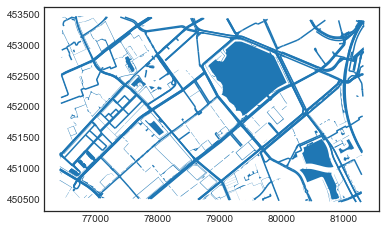

In [22]:
all_barriers.plot()

In [23]:
def eliminate_intersections(G, barriers_gdf):
    # eliminate all road segments that
    # - cross a barrier
    # - and do not allow for safe crossing, i.e. via a bridge or tunnel with dedicated pedestrian infrastructure    
    
    G_out = G.copy()
    
    barriers = barriers_gdf.geometry.unary_union
    
    for u, v, k, segment in G.edges(data=True, keys=True):
        # it the segment intersects with a barrier
        if segment['geometry'].intersects(barriers):
            # check if safe crossing is possible: bridge or tunnel
            if ('bridge' in segment.keys() and segment['bridge']=='yes') or ('tunnel' in segment.keys() and segment['tunnel']=='yes'):
                # check if pedestrian highway, and not just a sidewalk
                if ('highway' in segment.keys()) and ('pedestrian' or 'footway' or 'living_street' or 'track' or 'path' in segment['highway']):
                    if ('footway' in segment.keys()) and (segment['footway']=='sidewalk'):
                        # this is just a sidewalk, not safe enough, remove it
                        G_out.remove_edge(u, v)
                    else:
                        # this is a safe crossing, keep it
                        pass
                # check if designated to foot, and not just a sidewalk
                elif ('foot' in segment.keys()) and (segment['foot']=='designated'):
                    if ('footway' in segment.keys()) and (segment['footway']=='sidewalk'):
                        # this is just a sidewalk, not safe enough, remove it
                        G_out.remove_edge(u, v)
                    else:
                        # this is a safe crossing, keep it
                        pass
                else:
                    # this is not a safe crossing, remove it
                    G_out.remove_edge(u, v)
            else:
                # this is not a safe crossing, remove it
                G_out.remove_edge(u, v)
                
    G_out = ox.utils_graph.remove_isolated_nodes(G_out)
    
    return G_out


In [24]:
G_independent = eliminate_intersections(G, all_barriers)

In [25]:
paths_independent = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G_independent), nodes=False, edges=True).to_crs(local_crs)

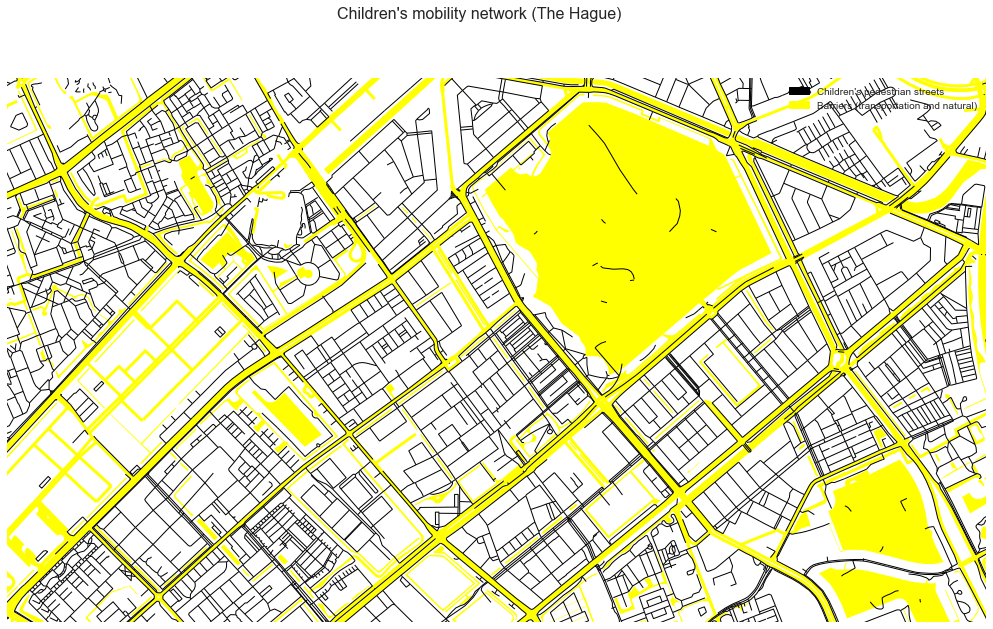

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
fig.suptitle('Children\'s mobility network ({})'.format(place_name), fontsize=16)

paths_independent.plot(ax=axs, figsize=(12, 20), color='black', linewidth=1, zorder=2)
all_barriers.plot(ax=axs, color='yellow', linewidth=3, zorder=1)

patch1 = mpatches.Patch(color='black', label='Children\'s pedestrian streets')
patch2 = mpatches.Patch(color='yellow', label='Barriers (transportation and natural)')
handles = [patch1, patch2]
axs.legend(handles=handles)

bbox_plot = place.total_bounds
margin = 0
xlim = ([bbox_plot[0]-margin, bbox_plot[2]+margin])
ylim = ([bbox_plot[1]-margin, bbox_plot[3]+margin])
axs.set_xlim(xlim)
axs.set_ylim(ylim)
axs.axis('off')
    
plt.show()

## Attractions

In [27]:
playground_attraction = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'playground_attraction.geojson'))
playground_attraction.crs = local_crs

schoolyard_attraction = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'schoolyard_attraction.geojson'))
schoolyard_attraction.crs = local_crs

small_park_attraction = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'small_park_attraction.geojson'))
small_park_attraction.crs = local_crs

## Calculating Accessibility

In [28]:
# permissable distance between play space and road segment
# as these are often not directly intersected by a road, especially when represented in OSM as POIs instead of polygons
dist = 25

### Baseline 1: Euclidean distance access to playgrounds
i.e., baseline, no network, no barriers, no spectrum of destinations

In [29]:
def get_euclideans(gdf, trip_distances):
    for td in trip_distances:
        col = 'geom_eucl_' + str(td)
        gdf[col] = gdf.geometry.buffer(td)

In [30]:
playground_euclidean_access = playground_attraction.copy()
playground_euclidean_access.geometry = playground_euclidean_access.geometry.buffer(dist)
get_euclideans(playground_euclidean_access, trip_distances)

### Baseline 2: Network distance access to playgrounds
i.e., adding network distances

In [31]:
playground_network_access = playground_attraction.copy()
playground_network_access.geometry = playground_network_access.geometry.buffer(dist)
get_isochrones(G, playground_network_access, trip_distances, local_crs)

<AxesSubplot:>

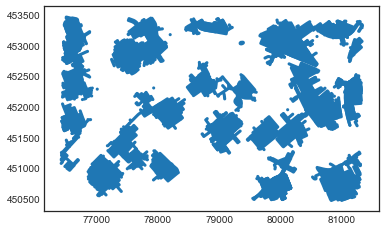

In [32]:
playground_network_access.set_geometry('geom_iso_300').plot()

### Novel: Network distance access to playgrounds, schoolyards, small parks
i.e., adding spectrum of destinations

In [33]:
schoolyard_network_access = schoolyard_attraction.copy()
schoolyard_network_access.geometry = schoolyard_network_access.geometry.buffer(dist)
get_isochrones(G, schoolyard_network_access, trip_distances, local_crs)

In [34]:
small_park_network_access = small_park_attraction.copy()
small_park_network_access.geometry = small_park_network_access.geometry.buffer(dist)
get_isochrones(G, small_park_network_access, trip_distances, local_crs)

### Novel final: Child's play access to playgrounds, schoolyards, small parks
i.e., adding barriers

In [35]:
playground_childsplay_access = playground_attraction.copy()
playground_childsplay_access.geometry = playground_childsplay_access.geometry.buffer(dist)
get_isochrones(G_independent, playground_childsplay_access, trip_distances, local_crs)

In [36]:
schoolyard_childsplay_access = schoolyard_attraction.copy()
schoolyard_childsplay_access.geometry = schoolyard_childsplay_access.geometry.buffer(dist)
get_isochrones(G_independent, schoolyard_childsplay_access, trip_distances, local_crs)

In [37]:
small_park_childsplay_access = small_park_attraction.copy()
small_park_childsplay_access.geometry = small_park_childsplay_access.geometry.buffer(dist)
get_isochrones(G_independent, small_park_childsplay_access, trip_distances, local_crs)

#  Store output data

In [53]:
# playground_euclidean_access
output_file = os.path.join(output_folder, output_sub_folder, 'playground_euclidean_access.geojson')
playground_euclidean_access_out = playground_euclidean_access.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
playground_euclidean_access_out.to_file(output_file, driver='GeoJSON')

In [54]:
# playground_network_access
output_file = os.path.join(output_folder, output_sub_folder, 'playground_network_access.geojson')
playground_network_access_out = playground_network_access.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
playground_network_access_out.to_file(output_file, driver='GeoJSON')

In [55]:
# schoolyard_network_access
output_file = os.path.join(output_folder, output_sub_folder, 'schoolyard_network_access.geojson')
schoolyard_network_access_out = schoolyard_network_access.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
schoolyard_network_access_out.to_file(output_file, driver='GeoJSON')

# small_park_network_access
output_file = os.path.join(output_folder, output_sub_folder, 'small_park_network_access.geojson')
small_park_network_access_out = small_park_network_access.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
small_park_network_access_out.to_file(output_file, driver='GeoJSON')

In [56]:
# playground_childsplay_access
output_file = os.path.join(output_folder, output_sub_folder, 'playground_childsplay_access.geojson')
playground_childsplay_access_out = playground_childsplay_access.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
playground_childsplay_access_out.to_file(output_file, driver='GeoJSON')

# schoolyard_childsplay_access
output_file = os.path.join(output_folder, output_sub_folder, 'schoolyard_childsplay_access.geojson')
schoolyard_childsplay_access_out = schoolyard_childsplay_access.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
schoolyard_childsplay_access_out.to_file(output_file, driver='GeoJSON')

# small_park_childsplay_access
output_file = os.path.join(output_folder, output_sub_folder, 'small_park_childsplay_access.geojson')
small_park_childsplay_access_out = small_park_childsplay_access.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
small_park_childsplay_access_out.to_file(output_file, driver='GeoJSON')

In [57]:
output_file = os.path.join(output_folder, output_sub_folder, 'paths.geojson')
paths_out = paths.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
paths_out.to_file(output_file, driver='GeoJSON')

In [58]:
output_file = os.path.join(output_folder, output_sub_folder, 'safe_crossings.geojson')
safe_crossings_out = safe_crossings.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
safe_crossings_out.to_file(output_file, driver='GeoJSON')

In [59]:
# playground_childsplay_access
output_file = os.path.join(output_folder, output_sub_folder, 'playground_childsplay_access_zones.geojson')
playground_childsplay_access_out = playground_childsplay_access.copy()
playground_childsplay_access_out['geometry'] = playground_childsplay_access_out['geom_iso_300']
playground_childsplay_access_out = playground_childsplay_access_out.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
playground_childsplay_access_out.to_file(output_file, driver='GeoJSON')

# schoolyard_childsplay_access
output_file = os.path.join(output_folder, output_sub_folder, 'schoolyard_childsplay_access_zones.geojson')
schoolyard_childsplay_access_out = schoolyard_childsplay_access.copy()
schoolyard_childsplay_access_out['geometry'] = schoolyard_childsplay_access_out['geom_iso_300']
schoolyard_childsplay_access_out = schoolyard_childsplay_access_out.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
schoolyard_childsplay_access_out.to_file(output_file, driver='GeoJSON')

# small_park_childsplay_access
output_file = os.path.join(output_folder, output_sub_folder, 'small_park_childsplay_access_zones.geojson')
small_park_childsplay_access_out = small_park_childsplay_access.copy()
small_park_childsplay_access_out['geometry'] = small_park_childsplay_access_out['geom_iso_300']
small_park_childsplay_access_out = small_park_childsplay_access_out.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
small_park_childsplay_access_out.to_file(output_file, driver='GeoJSON')